In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
import numpy as np
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
# Additional imports for clustering
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch.optim as optim
from torch.nn import MSELoss
import random



# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cpu


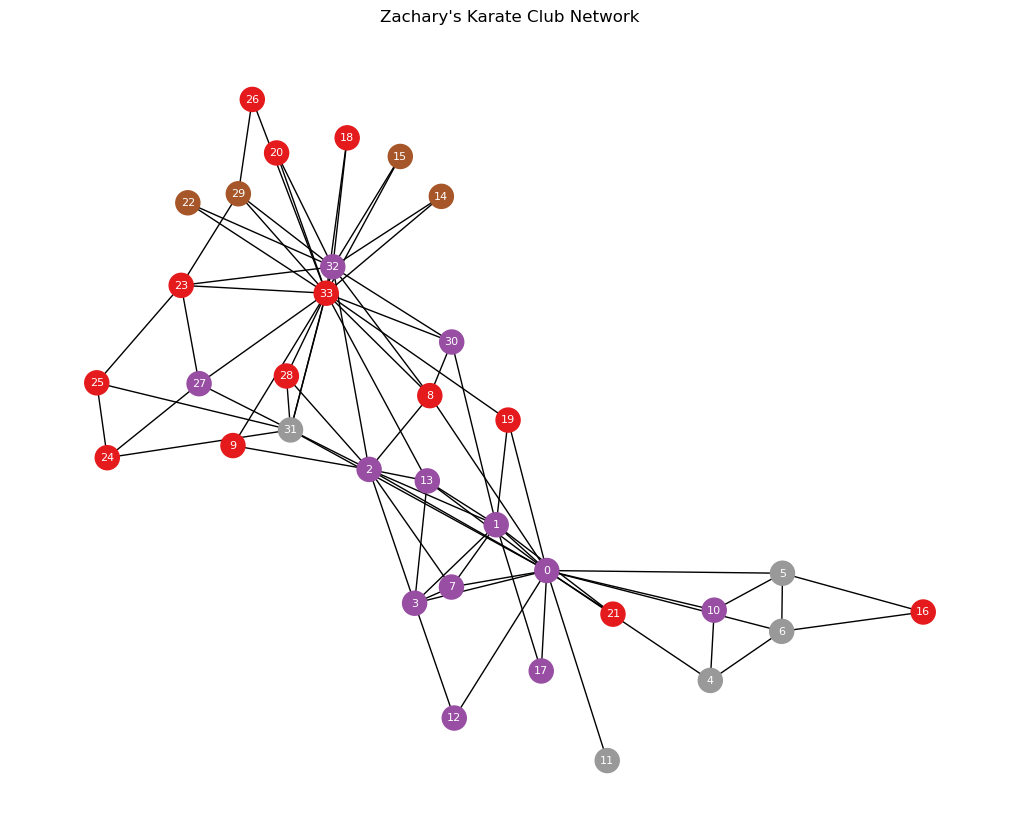

In [27]:
from torch_geometric.datasets import KarateClub
import networkx as nx
import matplotlib.pyplot as plt

# Load the Karate Club dataset
dataset = KarateClub()
data = dataset[0]

# Convert to NetworkX graph for visualization
G = nx.Graph()
edge_index = data.edge_index.numpy()
G.add_edges_from(edge_index.T)

# Get node labels (ground truth communities)
node_labels = data.y.numpy()

# Visualize the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)  # For consistent layout
nx.draw(G, pos, 
        node_color=node_labels, 
        cmap=plt.cm.Set1,  # Colormap for node communities
        with_labels=True,  # Show node labels
        node_size=300,     # Node size
        font_size=8,       # Label font size
        font_color='white' # Label color
       )
plt.title("Zachary's Karate Club Network")
plt.show()

# GNN Model 

In [28]:
from model import SimpleGAT,SimpleGCN,SimpleSAGE

# Unsupervised Loss Functions

In [29]:
from unsuper_loss import UnsupervisedLoss

# Clustering Algorithms

In [30]:
from evaluate import ClusteringEvaluator


# Evaluation

In [31]:
from evaluate import ClusteringEvaluator

# Unsupervised Training Pipeline

In [33]:
def train_unsupervised_gnn(model, data, epochs=200, lr=0.01, loss_type='contrastive'):
    """Train GNN in unsupervised manner."""
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    model.train()
    
    losses = []
    
    for epoch in tqdm(range(epochs), desc=f"Training ({loss_type})"):
        optimizer.zero_grad()
        
        embeddings = model(data)
        
        if loss_type == 'contrastive':
            loss = UnsupervisedLoss.contrastive_loss(embeddings, data.edge_index)
        elif loss_type == 'proximity':
            loss = UnsupervisedLoss.proximity_loss(embeddings, data.edge_index)
        else:
            raise ValueError(f"Unknown loss type: {loss_type}")
            
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch + 1:3d}, Loss: {loss.item():.4f}")
    
    return model, losses

def train_autoencoder_gnn(autoencoder, data, epochs=200, lr=0.01):
    """Train Graph Autoencoder."""
    optimizer = optim.Adam(autoencoder.parameters(), lr=lr, weight_decay=5e-4)
    autoencoder.train()
    
    losses = []
    
    for epoch in tqdm(range(epochs), desc="Training (Autoencoder)"):
        optimizer.zero_grad()
        
        embeddings, reconstructed = autoencoder(data)
        
        # Reconstruction loss (reconstruct node features)
        recon_loss = UnsupervisedLoss.reconstruction_loss(data.x, reconstructed)
        # Add proximity loss for connected nodes
        prox_loss = UnsupervisedLoss.proximity_loss(embeddings, data.edge_index)
        
        loss = recon_loss + 0.1 * prox_loss
        
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch + 1:3d}, Loss: {loss.item():.4f} (Recon: {recon_loss.item():.4f}, Prox: {prox_loss.item():.4f})")
    
    return autoencoder, losses

def run_clustering_pipeline(model, data, n_clusters=2, true_labels=None):
    """Complete clustering pipeline."""
    print("\n" + "="*60)
    print("UNSUPERVISED CLUSTERING PIPELINE")
    print("="*60)
    
    # Get embeddings
    model.eval()
    with torch.no_grad():
        embeddings = model(data)
    
    # Initialize clustering
    clusterer = GraphClustering(n_clusters=n_clusters)
    evaluator = ClusteringEvaluator()
    
    results_summary = {}
    
    # K-means clustering
    print("\n1. K-Means Clustering")
    kmeans_labels, _ = clusterer.kmeans_clustering(embeddings)
    kmeans_results = evaluator.evaluate_clustering(true_labels, kmeans_labels, embeddings)
    evaluator.print_results(kmeans_results, "K-Means")
    results_summary['K-Means'] = kmeans_results
    
    # Spectral clustering
    print("\n2. Spectral Clustering")
    spectral_labels, _ = clusterer.spectral_clustering(embeddings)
    spectral_results = evaluator.evaluate_clustering(true_labels, spectral_labels, embeddings)
    evaluator.print_results(spectral_results, "Spectral")
    results_summary['Spectral'] = spectral_results
    
    # Hierarchical clustering
    print("\n3. Hierarchical Clustering")
    hierarchical_labels, _ = clusterer.hierarchical_clustering(embeddings)
    hierarchical_results = evaluator.evaluate_clustering(true_labels, hierarchical_labels, embeddings)
    evaluator.print_results(hierarchical_results, "Hierarchical")
    results_summary['Hierarchical'] = hierarchical_results
    
    return {
        'embeddings': embeddings,
        'clustering_results': {
            'kmeans': kmeans_labels,
            'spectral': spectral_labels,
            'hierarchical': hierarchical_labels
        },
        'evaluation_results': results_summary
    }

print("✓ Training pipeline defined")


✓ Training pipeline defined


# Complete Pipeline: Unsupervised Graph Clustering

In [35]:
def run_complete_clustering_example():
    """Run the complete unsupervised clustering example."""
    print("🚀 Starting Unsupervised Graph Clustering Experiment")
    print("="*70)
    
    # Load data
    dataset = KarateClub()
    data = dataset[0]
    true_labels = data.y.numpy()
    n_clusters = len(np.unique(true_labels))
    
    print(f"Dataset: Karate Club")
    print(f"Nodes: {data.num_nodes}")
    print(f"Edges: {data.num_edges}")
    print(f"Features: {data.num_node_features}")
    print(f"True clusters: {n_clusters}")
    
    # Model configurations
    models_config = {
        'GCN': SimpleGCN(data.num_node_features, 32, 16),
        'GAT': SimpleGAT(data.num_node_features, 16, 16, heads=2),
        'SAGE': SimpleSAGE(data.num_node_features, 32, 16)
    }
    
    all_results = {}
    
    # Test different approaches
    for model_name, model in models_config.items():
        print(f"\n{'='*70}")
        print(f"🔬 Testing {model_name} with different training approaches")
        print('='*70)
        
        # 1. Contrastive Learning Approach
        print(f"\n📊 {model_name} - Contrastive Learning")
        print("-" * 50)
        
        model_copy = type(model)(data.num_node_features, 
                               model.conv1.out_channels if hasattr(model.conv1, 'out_channels') else 32, 
                               16)
        trained_model, losses = train_unsupervised_gnn(
            model_copy, data, epochs=100, lr=0.01, loss_type='contrastive'
        )
        
        # Plot training loss
        plot_training_loss(losses, f"{model_name} - Contrastive Learning Loss")
        
        # Run clustering
        results = run_clustering_pipeline(trained_model, data, n_clusters, true_labels)
        
        # Visualizations
        plot_embeddings_and_clusters(
            results['embeddings'], 
            results['clustering_results'], 
            true_labels, data
        )
        plot_network_clusters(data, results['clustering_results'], true_labels)
        
        all_results[f'{model_name}_contrastive'] = results
        
        # 2. Proximity Learning Approach
        print(f"\n📊 {model_name} - Proximity Learning")
        print("-" * 50)
        
        model_copy2 = type(model)(data.num_node_features, 
                                model.conv1.out_channels if hasattr(model.conv1, 'out_channels') else 32, 
                                16)
        trained_model2, losses2 = train_unsupervised_gnn(
            model_copy2, data, epochs=100, lr=0.01, loss_type='proximity'
        )
        
        # Plot training loss
        plot_training_loss(losses2, f"{model_name} - Proximity Learning Loss")
        
        # Run clustering
        results2 = run_clustering_pipeline(trained_model2, data, n_clusters, true_labels)
        
        # Visualizations
        plot_embeddings_and_clusters(
            results2['embeddings'], 
            results2['clustering_results'], 
            true_labels, data
        )
        
        all_results[f'{model_name}_proximity'] = results2
    
    # Summary comparison
    print("\n" + "="*80)
    print("📋 FINAL RESULTS SUMMARY")
    print("="*80)
    
    summary_metrics = ['ARI', 'NMI', 'Silhouette']
    
    for metric in summary_metrics:
        print(f"\n🎯 {metric} Scores:")
        print("-" * 50)
        for exp_name, results in all_results.items():
            best_clustering = max(results['evaluation_results'].items(), 
                                key=lambda x: x[1].get(metric, -1))
            best_method, best_score = best_clustering
            print(f"{exp_name:25} | {best_method:12} | {best_score[metric]:.4f}")
    
    return all_results

# Run the complete example
print("✓ Complete clustering example ready to run!")


✓ Complete clustering example ready to run!


🚀 Starting Unsupervised Graph Clustering Experiment
Dataset: Karate Club
Nodes: 34
Edges: 156
Features: 34
True clusters: 4

🔬 Testing GCN with different training approaches

📊 GCN - Contrastive Learning
--------------------------------------------------


Training (contrastive): 100%|██████████| 100/100 [00:00<00:00, 940.63it/s]

Epoch  50, Loss: 0.3954
Epoch 100, Loss: 0.3779


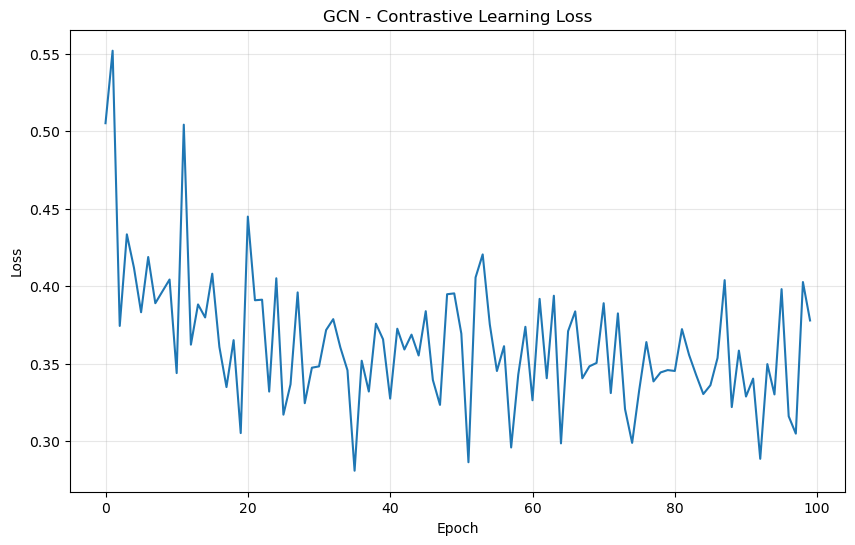


UNSUPERVISED CLUSTERING PIPELINE

1. K-Means Clustering

=== K-Means Results ===
ARI: 0.6962
NMI: 0.7481
Silhouette: 0.5313
Calinski_Harabasz: 49.4346
Davies_Bouldin: 0.5885

2. Spectral Clustering

=== Spectral Results ===
ARI: 0.6246
NMI: 0.6811
Silhouette: 0.5105
Calinski_Harabasz: 46.3270
Davies_Bouldin: 0.6546

3. Hierarchical Clustering

=== Hierarchical Results ===
ARI: 0.6962
NMI: 0.7481
Silhouette: 0.5313
Calinski_Harabasz: 49.4346
Davies_Bouldin: 0.5885


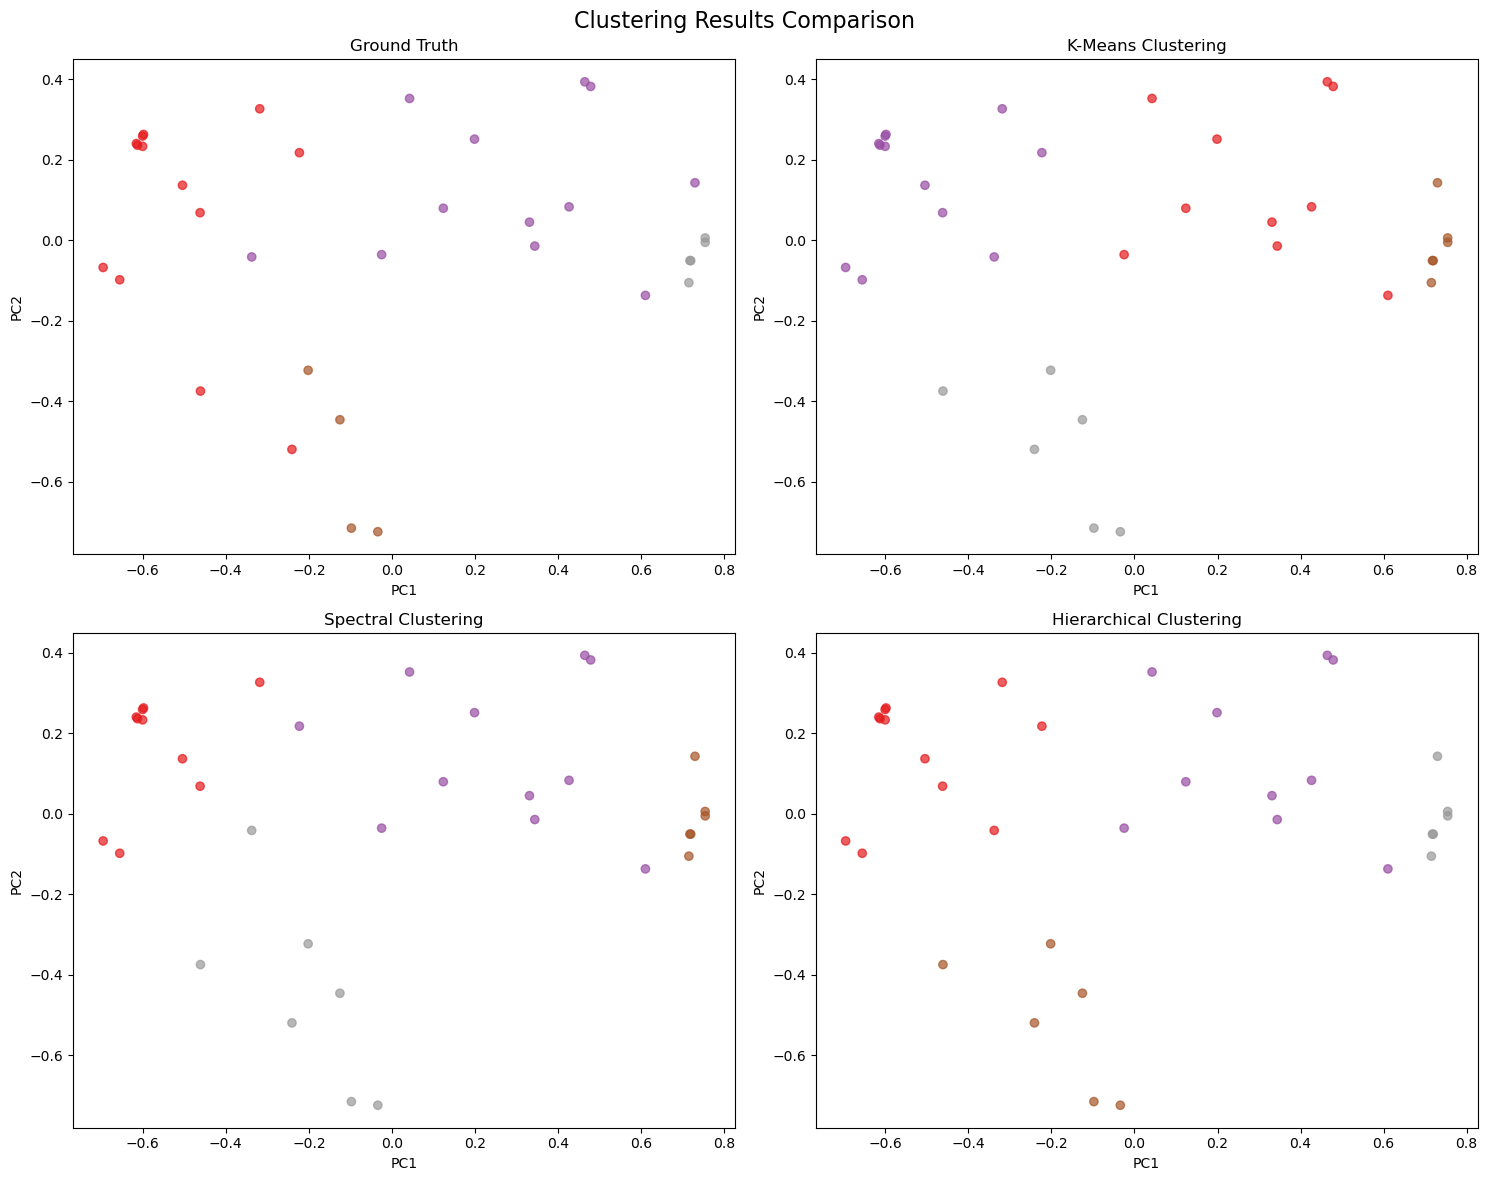

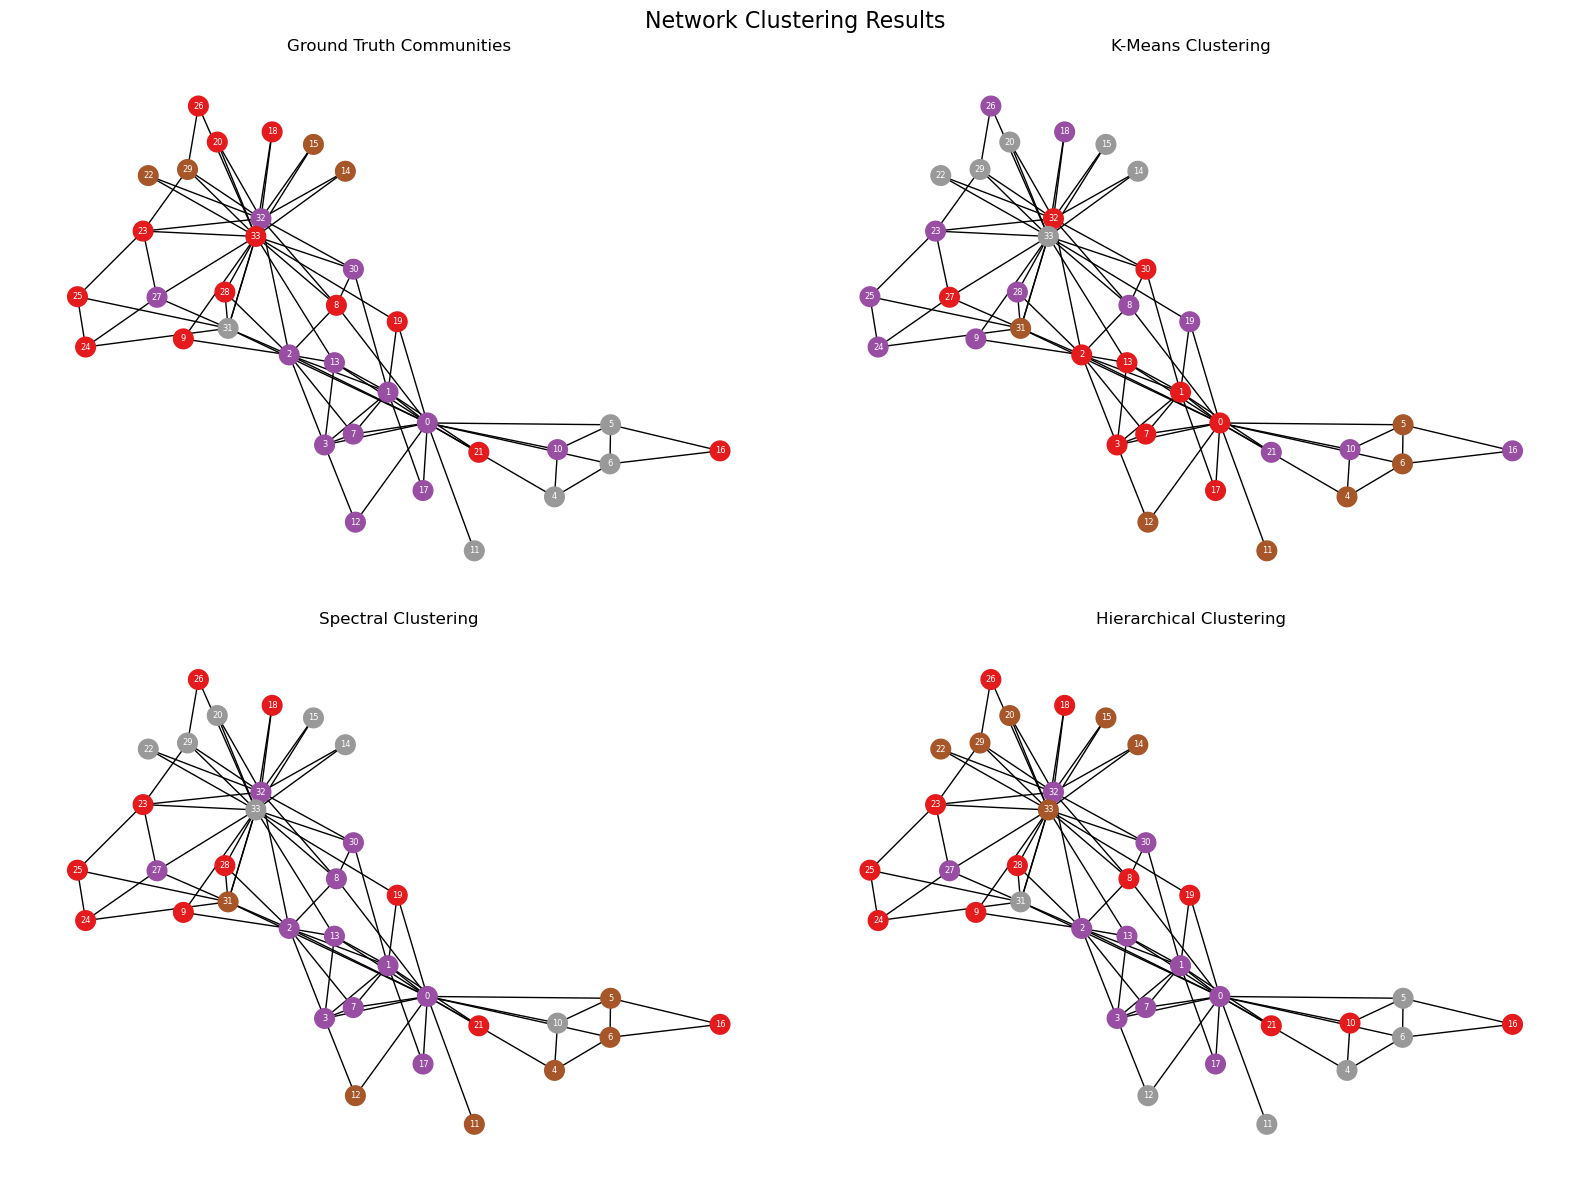


📊 GCN - Proximity Learning
--------------------------------------------------


Training (proximity): 100%|██████████| 100/100 [00:00<00:00, 1519.66it/s]

Epoch  50, Loss: 0.0000
Epoch 100, Loss: 0.0000


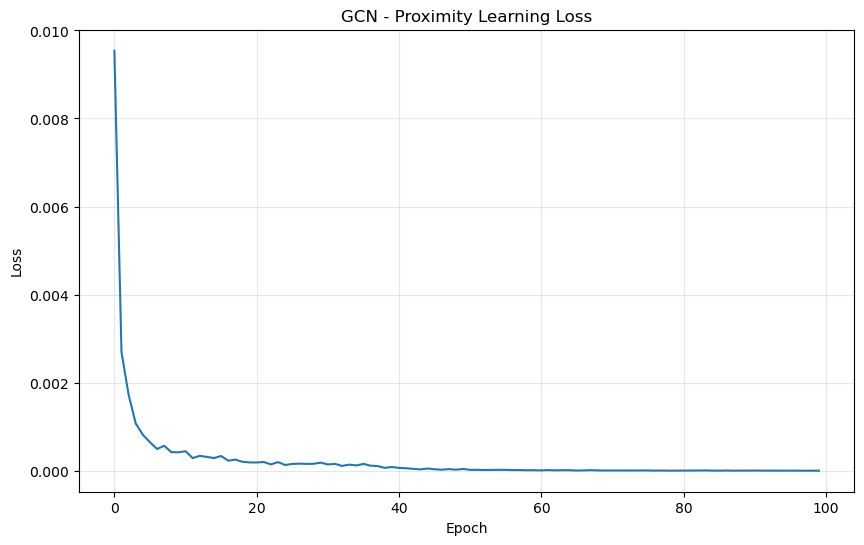


UNSUPERVISED CLUSTERING PIPELINE

1. K-Means Clustering

=== K-Means Results ===
ARI: 0.1147
NMI: 0.2432
Silhouette: 0.6447
Calinski_Harabasz: 204.9931
Davies_Bouldin: 0.4343

2. Spectral Clustering

=== Spectral Results ===
ARI: 0.0309
NMI: 0.1967
Silhouette: 0.4165
Calinski_Harabasz: 19.9193
Davies_Bouldin: 0.6584

3. Hierarchical Clustering

=== Hierarchical Results ===
ARI: 0.1147
NMI: 0.2432
Silhouette: 0.6447
Calinski_Harabasz: 204.9931
Davies_Bouldin: 0.4343


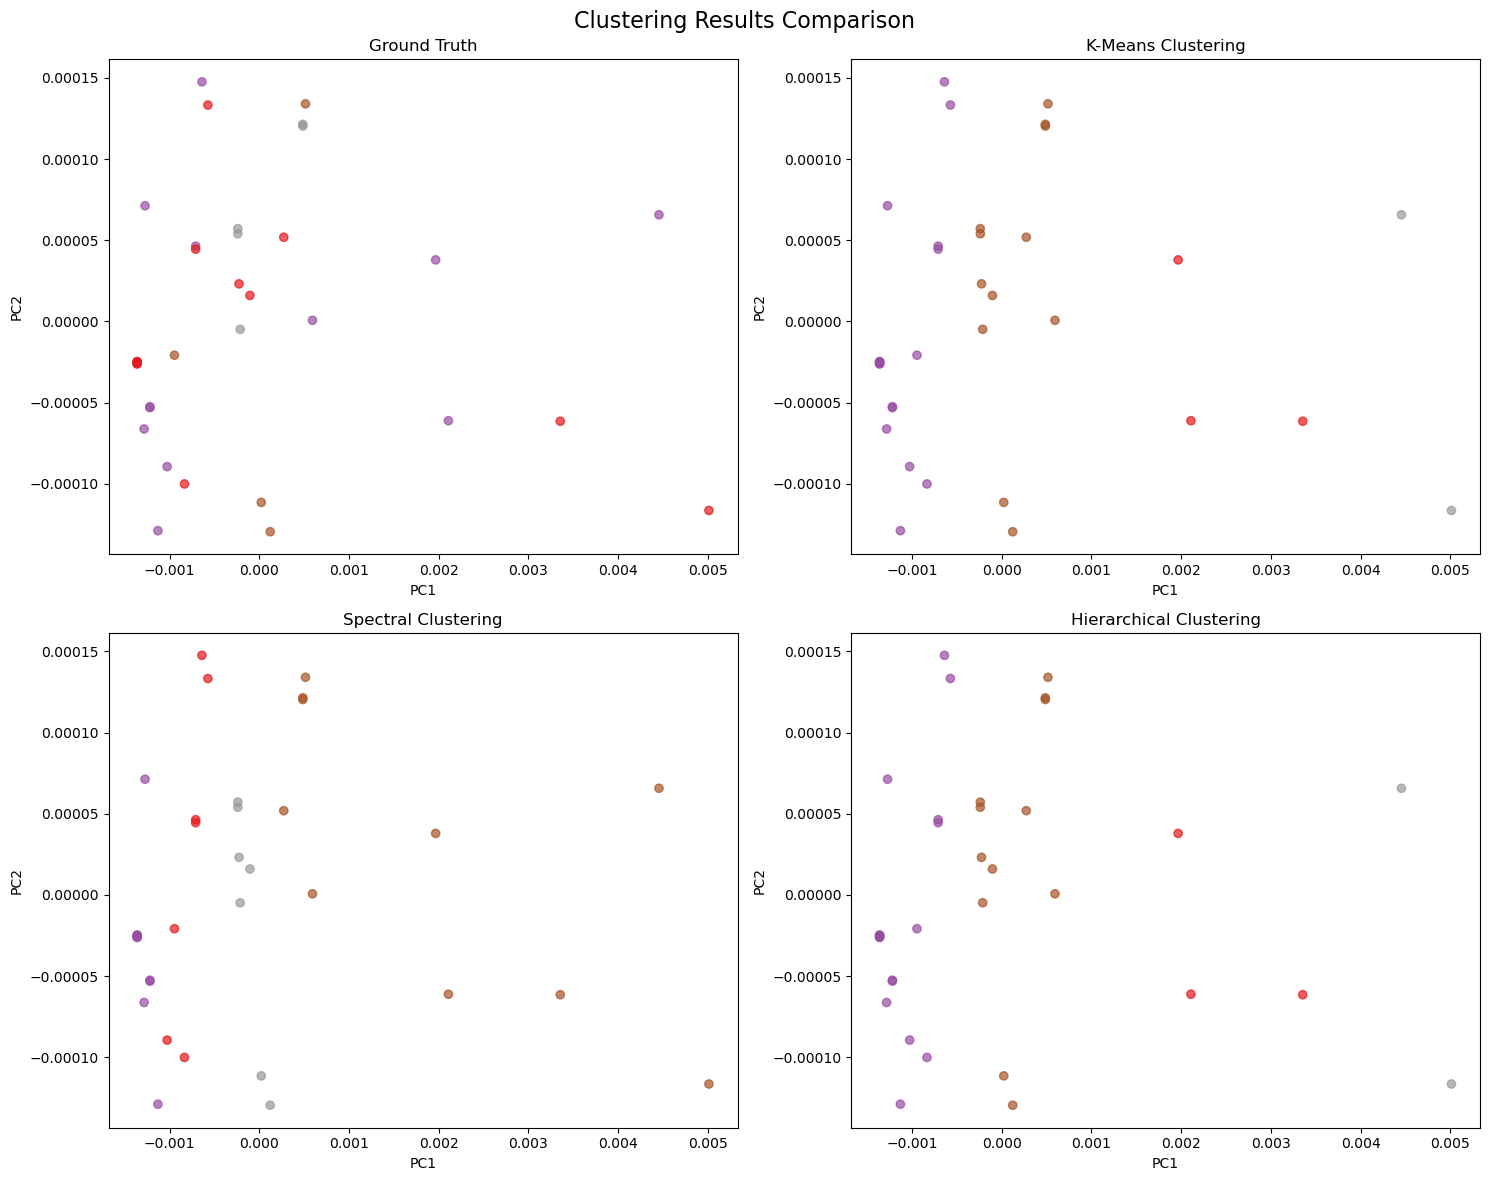


🔬 Testing GAT with different training approaches

📊 GAT - Contrastive Learning
--------------------------------------------------


Training (contrastive): 100%|██████████| 100/100 [00:00<00:00, 1084.09it/s]

Epoch  50, Loss: 0.4005
Epoch 100, Loss: 0.3552


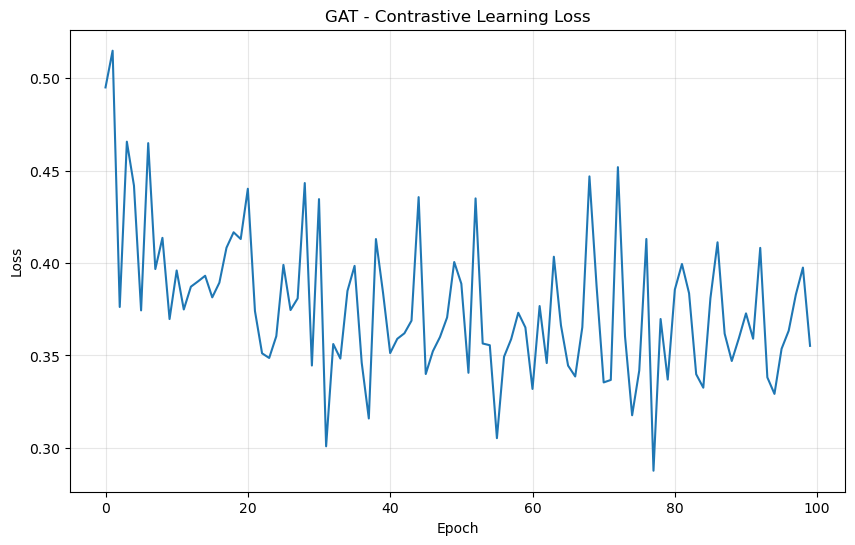


UNSUPERVISED CLUSTERING PIPELINE

1. K-Means Clustering

=== K-Means Results ===
ARI: 0.6962
NMI: 0.7481
Silhouette: 0.4347
Calinski_Harabasz: 31.6040
Davies_Bouldin: 0.7947

2. Spectral Clustering

=== Spectral Results ===
ARI: 0.6962
NMI: 0.7481
Silhouette: 0.4299
Calinski_Harabasz: 30.5319
Davies_Bouldin: 0.7450

3. Hierarchical Clustering

=== Hierarchical Results ===
ARI: 0.7357
NMI: 0.8025
Silhouette: 0.4014
Calinski_Harabasz: 25.9530
Davies_Bouldin: 0.8118


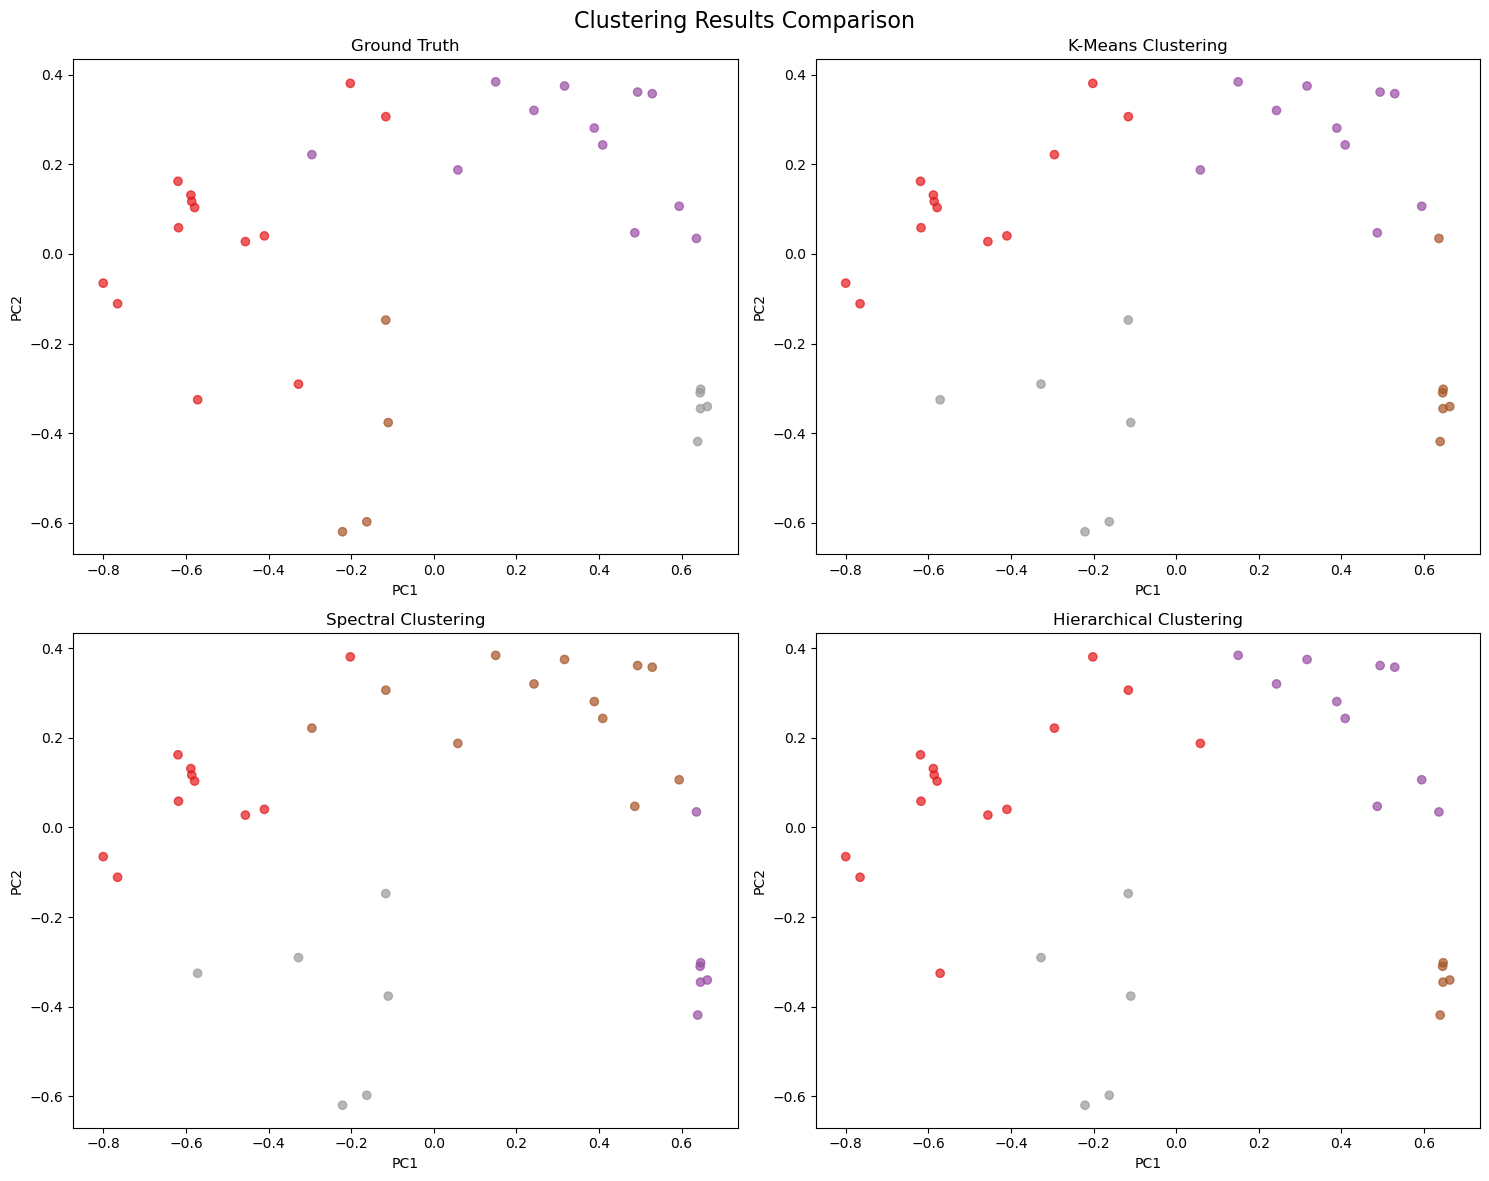

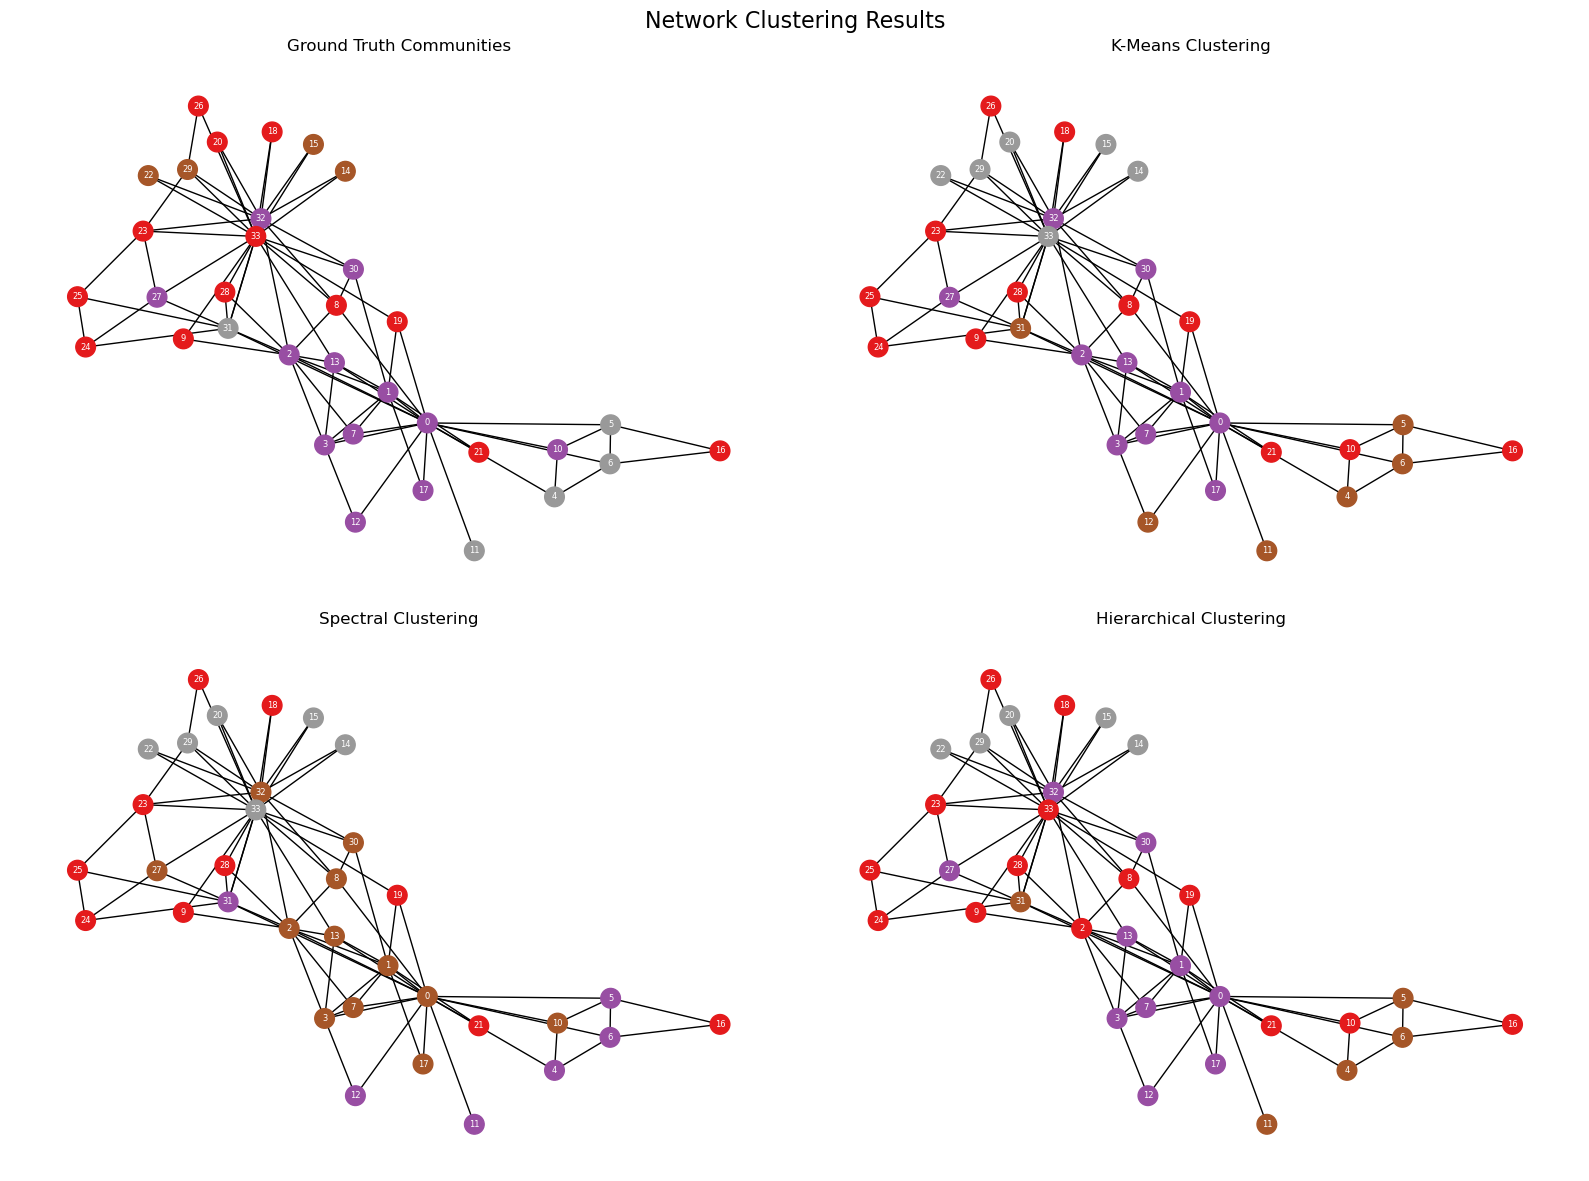


📊 GAT - Proximity Learning
--------------------------------------------------


Training (proximity): 100%|██████████| 100/100 [00:00<00:00, 671.60it/s]

Epoch  50, Loss: 0.0001
Epoch 100, Loss: 0.0000


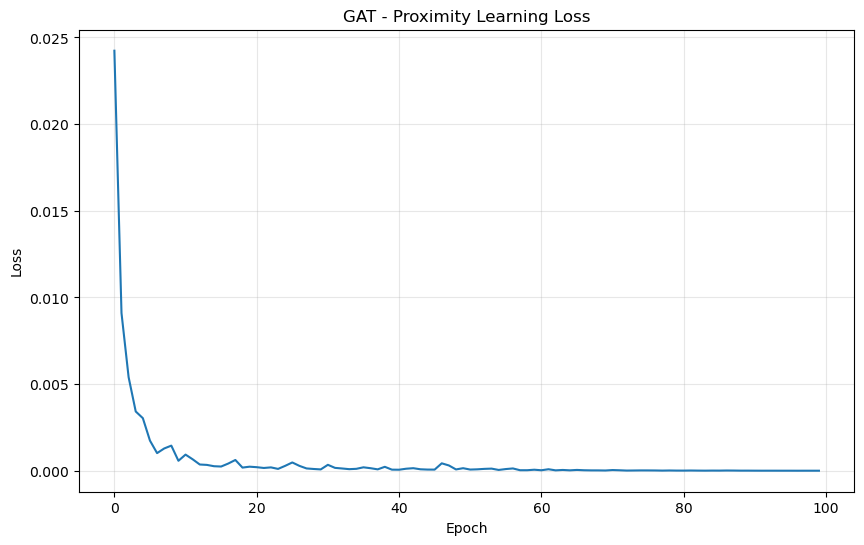


UNSUPERVISED CLUSTERING PIPELINE

1. K-Means Clustering

=== K-Means Results ===
ARI: 0.5679
NMI: 0.6400
Silhouette: 0.3483
Calinski_Harabasz: 22.6995
Davies_Bouldin: 1.0452

2. Spectral Clustering

=== Spectral Results ===
ARI: 0.5679
NMI: 0.6400
Silhouette: 0.3156
Calinski_Harabasz: 21.9106
Davies_Bouldin: 1.0651

3. Hierarchical Clustering

=== Hierarchical Results ===
ARI: 0.4476
NMI: 0.6307
Silhouette: 0.3157
Calinski_Harabasz: 22.1716
Davies_Bouldin: 1.0848


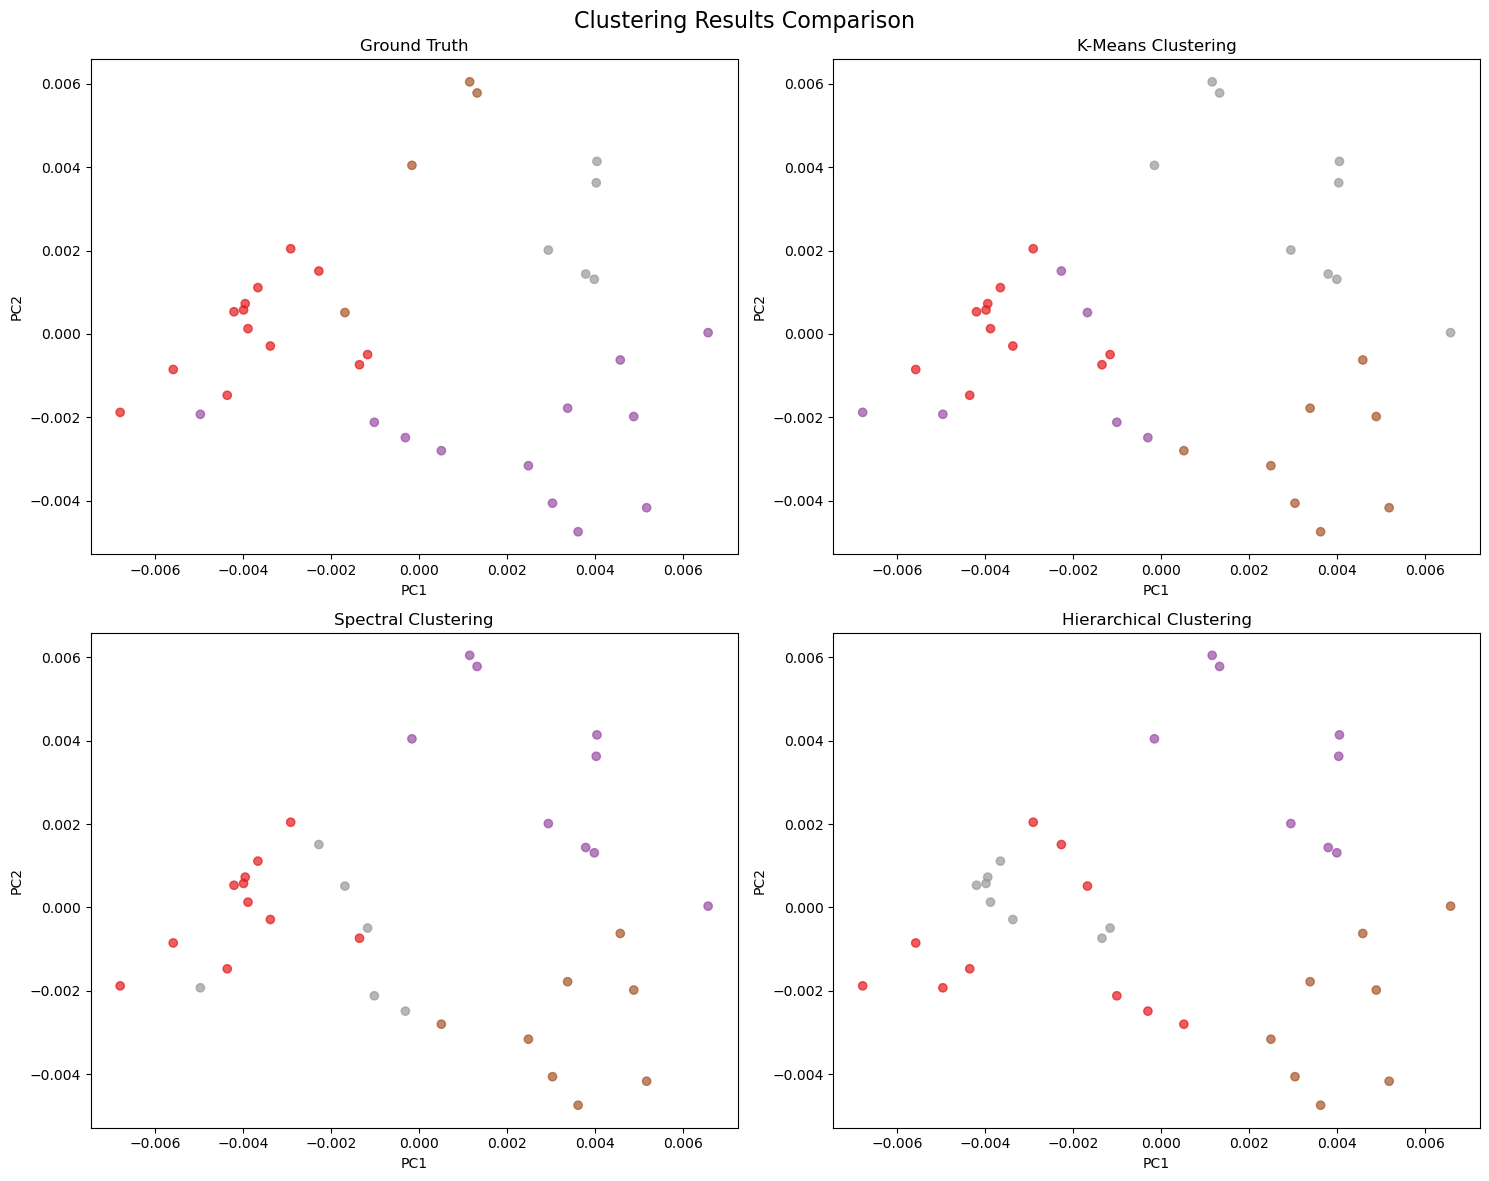


🔬 Testing SAGE with different training approaches

📊 SAGE - Contrastive Learning
--------------------------------------------------


Training (contrastive): 100%|██████████| 100/100 [00:00<00:00, 1346.44it/s]

Epoch  50, Loss: 0.4134
Epoch 100, Loss: 0.3125


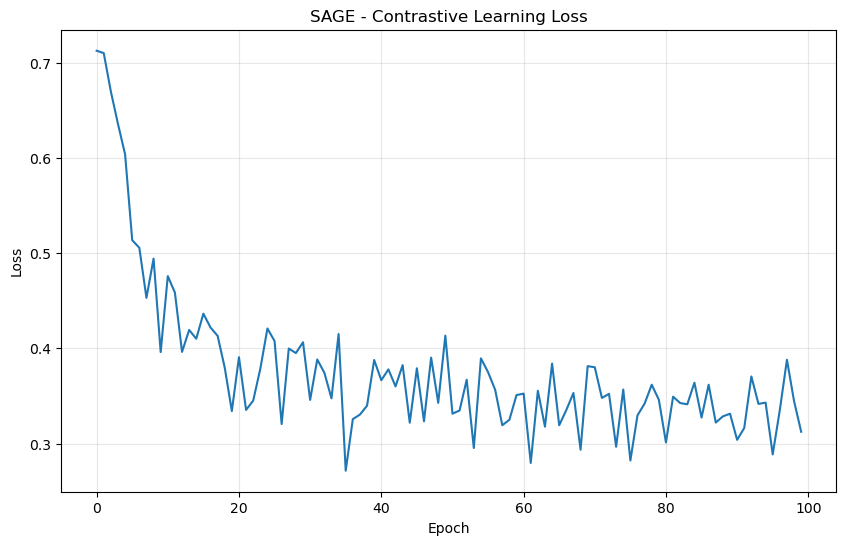


UNSUPERVISED CLUSTERING PIPELINE

1. K-Means Clustering

=== K-Means Results ===
ARI: 0.7665
NMI: 0.8150
Silhouette: 0.4250
Calinski_Harabasz: 31.5129
Davies_Bouldin: 0.7713

2. Spectral Clustering

=== Spectral Results ===
ARI: 0.5809
NMI: 0.6870
Silhouette: 0.3928
Calinski_Harabasz: 30.1810
Davies_Bouldin: 0.8653

3. Hierarchical Clustering

=== Hierarchical Results ===
ARI: 0.7357
NMI: 0.8025
Silhouette: 0.3977
Calinski_Harabasz: 26.9700
Davies_Bouldin: 0.7648


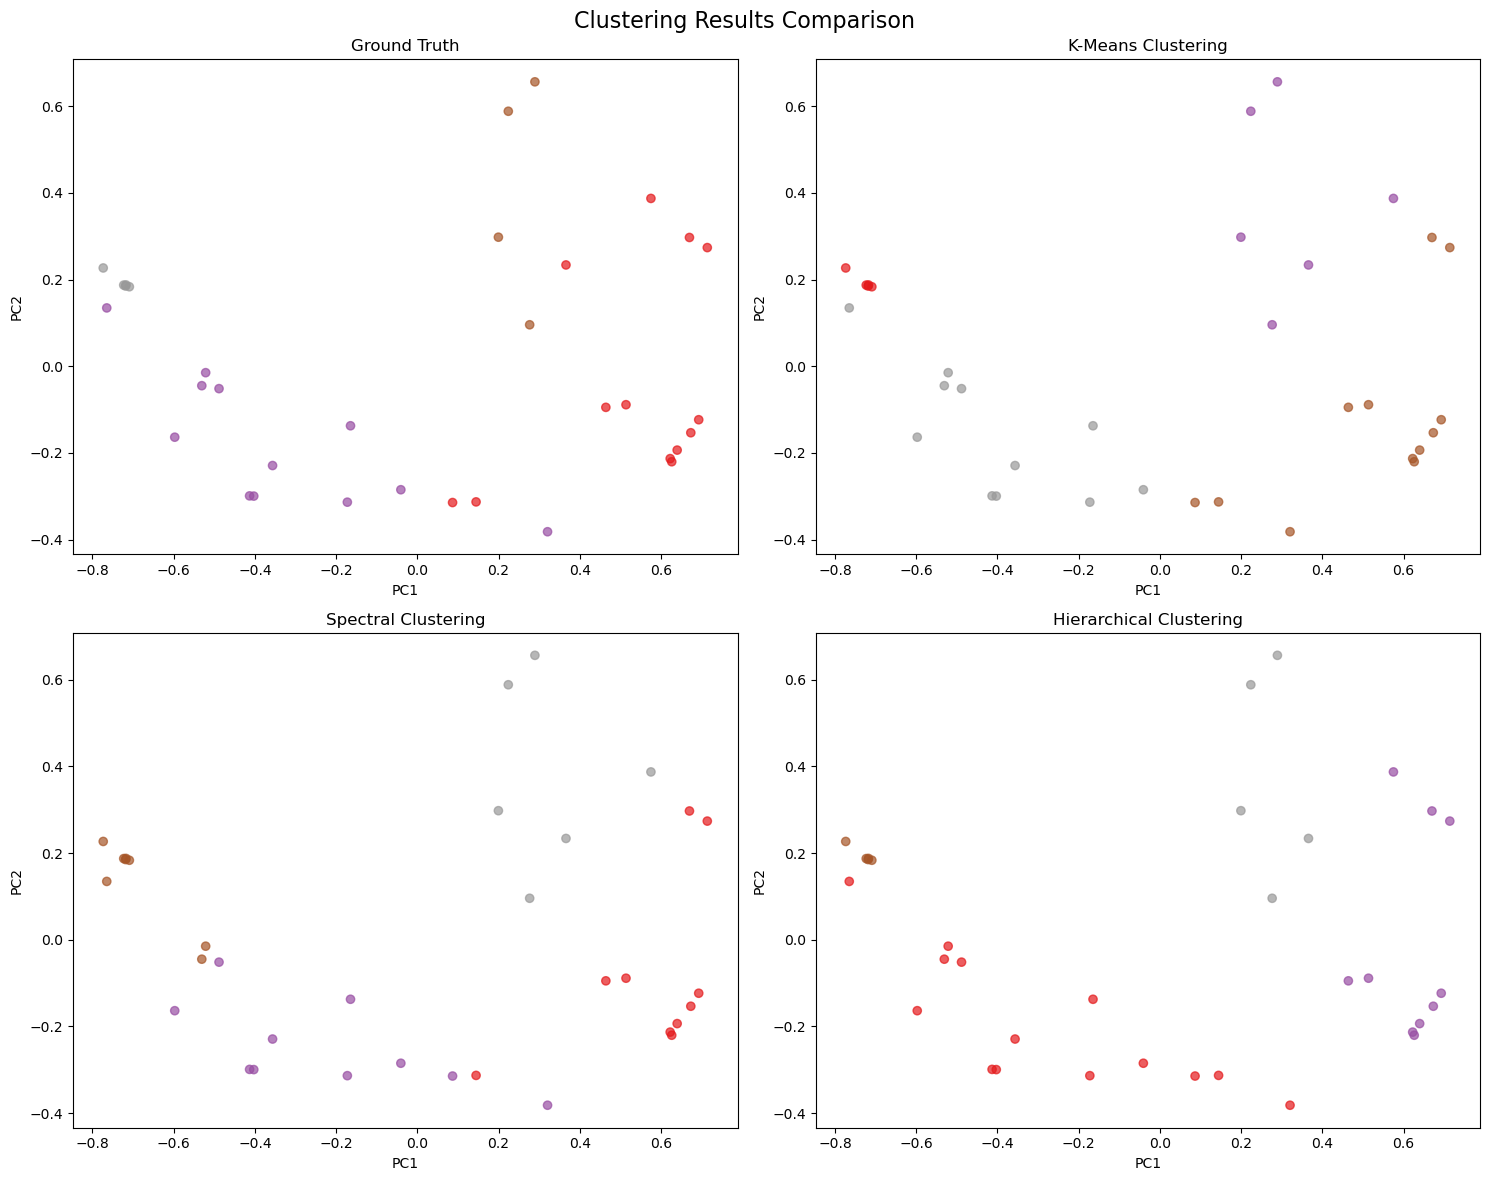

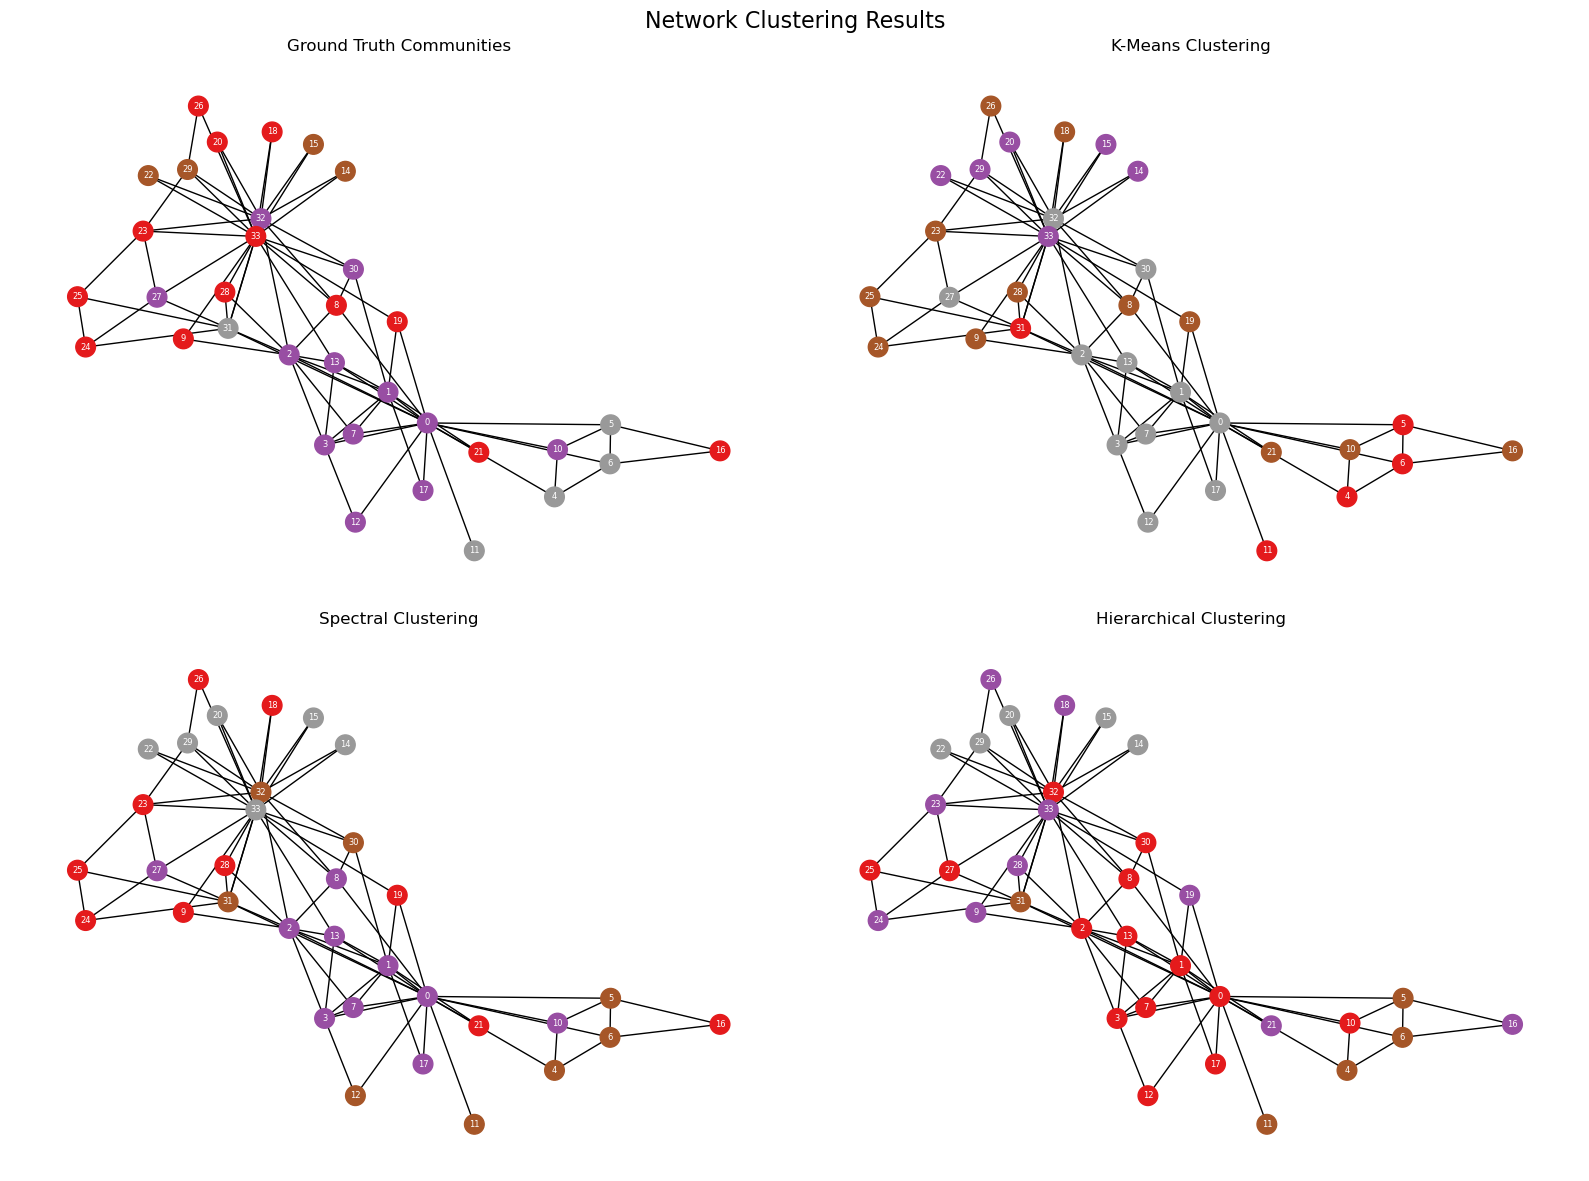


📊 SAGE - Proximity Learning
--------------------------------------------------


Training (proximity): 100%|██████████| 100/100 [00:00<00:00, 960.50it/s]

Epoch  50, Loss: 0.0000
Epoch 100, Loss: 0.0000


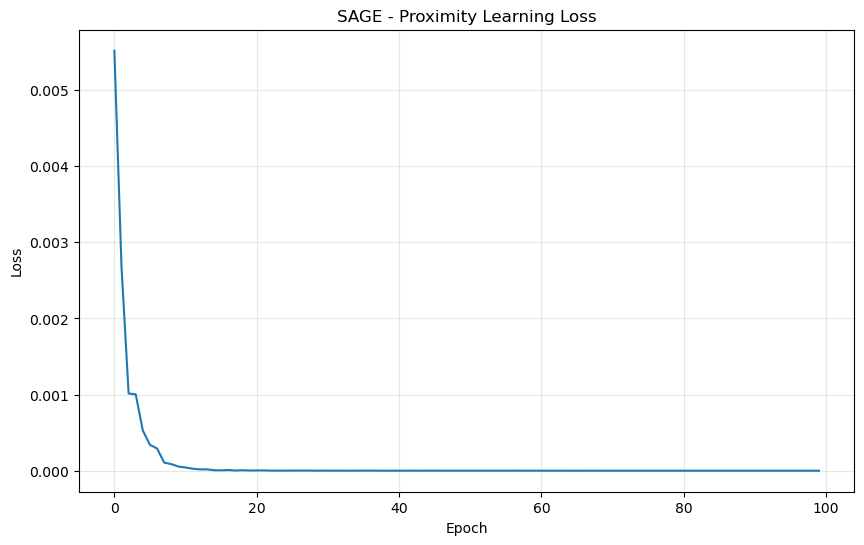


UNSUPERVISED CLUSTERING PIPELINE

1. K-Means Clustering

=== K-Means Results ===
ARI: 0.0985
NMI: 0.2433
Silhouette: 0.2300
Calinski_Harabasz: 87.6055
Davies_Bouldin: 2.0020

2. Spectral Clustering

=== Spectral Results ===
ARI: 0.1244
NMI: 0.2639
Silhouette: 0.2173
Calinski_Harabasz: 85.6653
Davies_Bouldin: 1.9991

3. Hierarchical Clustering

=== Hierarchical Results ===
ARI: 0.1522
NMI: 0.3051
Silhouette: 0.2253
Calinski_Harabasz: 81.2031
Davies_Bouldin: 2.4609


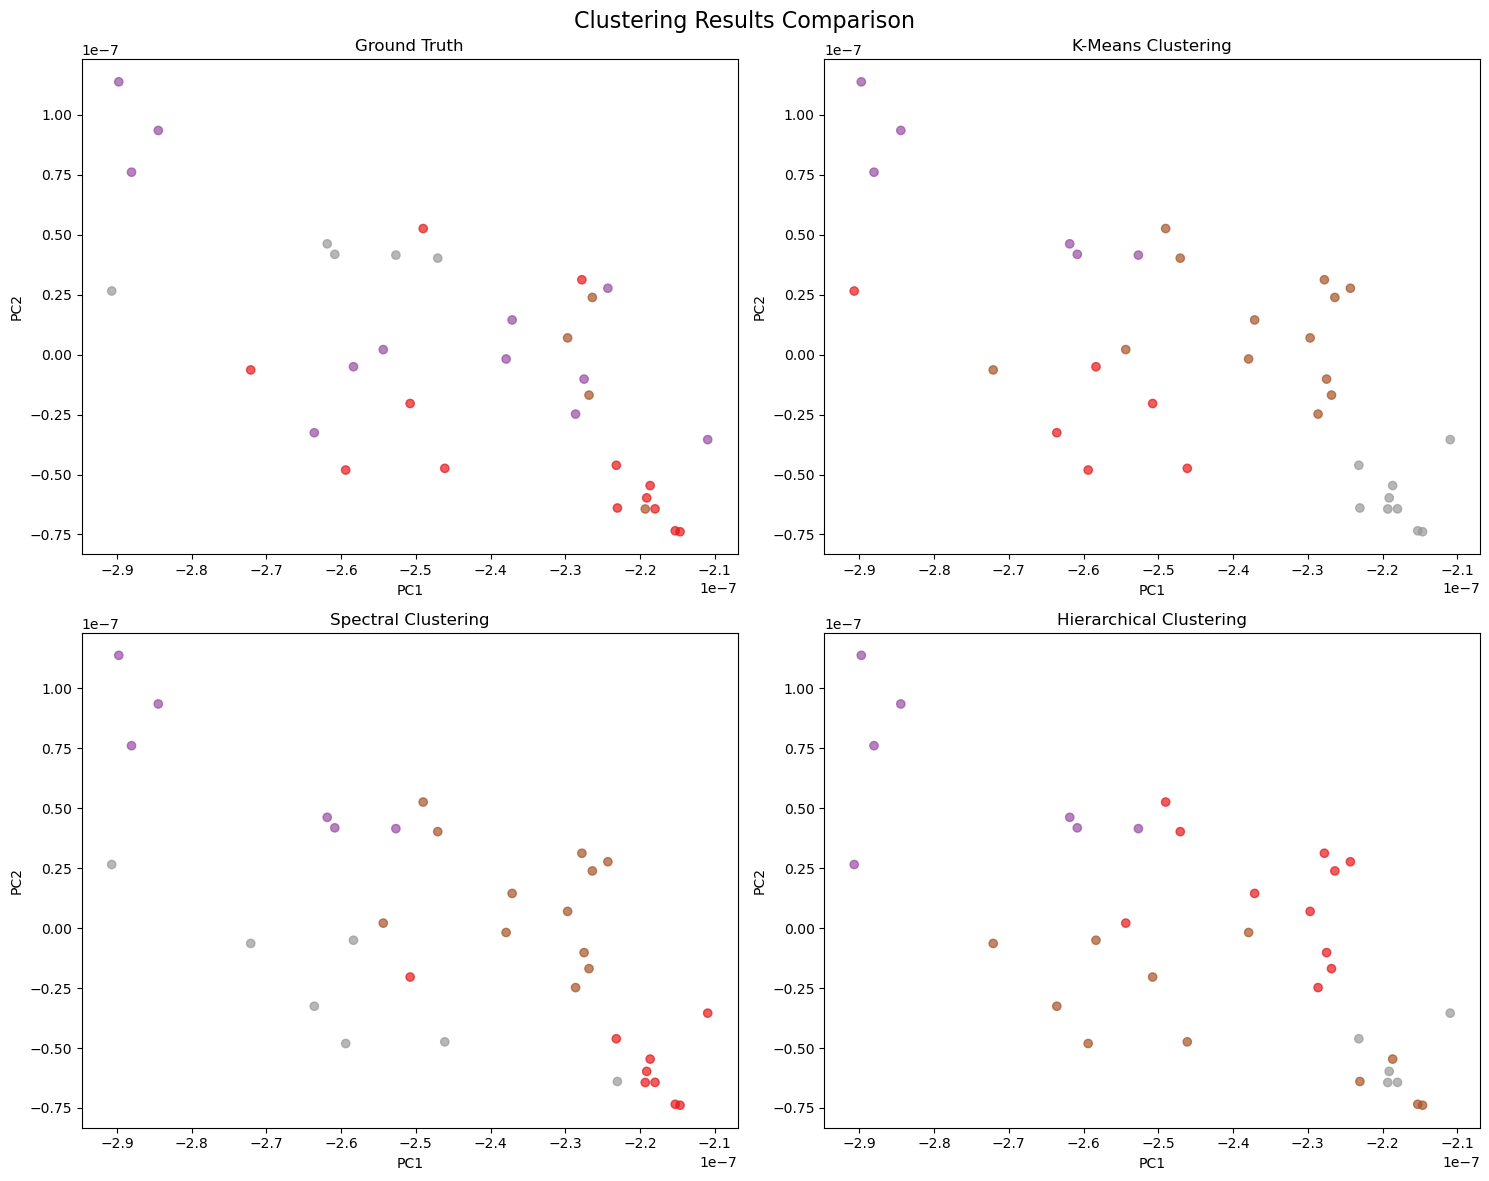


📋 FINAL RESULTS SUMMARY

🎯 ARI Scores:
--------------------------------------------------
GCN_contrastive           | K-Means      | 0.6962
GCN_proximity             | K-Means      | 0.1147
GAT_contrastive           | Hierarchical | 0.7357
GAT_proximity             | K-Means      | 0.5679
SAGE_contrastive          | K-Means      | 0.7665
SAGE_proximity            | Hierarchical | 0.1522

🎯 NMI Scores:
--------------------------------------------------
GCN_contrastive           | K-Means      | 0.7481
GCN_proximity             | K-Means      | 0.2432
GAT_contrastive           | Hierarchical | 0.8025
GAT_proximity             | K-Means      | 0.6400
SAGE_contrastive          | K-Means      | 0.8150
SAGE_proximity            | Hierarchical | 0.3051

🎯 Silhouette Scores:
--------------------------------------------------
GCN_contrastive           | K-Means      | 0.5313
GCN_proximity             | K-Means      | 0.6447
GAT_contrastive           | K-Means      | 0.4347
GAT_proximity       

In [25]:
results = run_complete_clustering_example()

In [ ]:
# SAFER VERSION: Execute clustering pipeline step by step
# This prevents memory overflow and allows better debugging

print("🔧 Starting SAFE clustering pipeline...")

# Step 1: Load and check data
try:
    from torch_geometric.datasets import KarateClub
    dataset = KarateClub()
    data = dataset[0]
    true_labels = data.y.numpy()
    n_clusters = len(np.unique(true_labels))
    
    print(f"✓ Dataset loaded successfully")
    print(f"  Nodes: {data.num_nodes}")
    print(f"  Edges: {data.num_edges}")
    print(f"  Features: {data.num_node_features}")
    print(f"  True clusters: {n_clusters}")
except Exception as e:
    print(f"✗ Error loading dataset: {e}")

# Step 2: Test one small model first
try:
    # Use smaller model to avoid memory issues
    print("\n🧪 Testing small GCN model...")
    small_model = SimpleGCN(data.num_node_features, 16, 8)  # Smaller dimensions
    
    # Shorter training to test stability
    trained_model, losses = train_unsupervised_gnn(
        small_model, data, epochs=20, lr=0.01, loss_type='contrastive'  # Only 20 epochs
    )
    print("✓ Small model training completed successfully")
    
    # Quick clustering test
    clusterer = GraphClustering(n_clusters=n_clusters)
    evaluator = ClusteringEvaluator()
    
    with torch.no_grad():
        embeddings = trained_model(data)
    
    kmeans_labels, _ = clusterer.kmeans_clustering(embeddings)
    results = evaluator.evaluate_clustering(true_labels, kmeans_labels, embeddings)
    
    print("✓ Quick clustering test completed")
    print(f"  ARI: {results['ARI']:.4f}")
    print(f"  NMI: {results['NMI']:.4f}")
    
except Exception as e:
    print(f"✗ Error in model testing: {e}")
    print("This might indicate memory or compatibility issues.")

print("\n✅ Safe pipeline test completed!")


🔧 Starting SAFE clustering pipeline...
✓ Dataset loaded successfully
  Nodes: 34
  Edges: 156
  Features: 34
  True clusters: 4

🧪 Testing small GCN model...


Training (contrastive): 100%|██████████| 20/20 [00:00<00:00, 132.90it/s]

✓ Small model training completed successfully


✓ Quick clustering test completed
  ARI: 0.4924
  NMI: 0.6521

✅ Safe pipeline test completed!


: 

# Adapt to MILP data

In [ ]:

# def apply_to_custom_data(data_loader, num_features, embedding_dim=64, n_clusters=None):
#     """
#     Apply unsupervised clustering to your custom graph dataset.
    
#     Args:
#         data_loader: Your PyTorch Geometric DataLoader
#         num_features: Number of node features in your graphs
#         embedding_dim: Dimension of the learned embeddings
#         n_clusters: Number of clusters (if None, will try to estimate)
#     """
    
#     # Choose your model architecture
#     model = SimpleGCN(num_features, 64, embedding_dim)
    
#     all_embeddings = []
#     all_results = []
    
#     for batch_idx, batch_data in enumerate(data_loader):
#         print(f"Processing batch {batch_idx + 1}/{len(data_loader)}")
        
#         # Train the model on this batch unsupervised
#         trained_model, losses = train_unsupervised_gnn(
#             model, batch_data, epochs=50, lr=0.01, loss_type='contrastive'
#         )
        
#         # Estimate number of clusters if not provided
#         if n_clusters is None:
#             # Try different cluster numbers and use silhouette score
#             best_k = 2
#             best_score = -1
#             for k in range(2, min(10, batch_data.num_nodes//2)):
#                 clusterer = GraphClustering(n_clusters=k)
#                 with torch.no_grad():
#                     emb = trained_model(batch_data)
#                 labels, _ = clusterer.kmeans_clustering(emb)
#                 score = silhouette_score(emb.detach().cpu().numpy(), labels)
#                 if score > best_score:
#                     best_score = score
#                     best_k = k
#             n_clusters_to_use = best_k
#         else:
#             n_clusters_to_use = n_clusters
        
#         # Run clustering pipeline
#         results = run_clustering_pipeline(
#             trained_model, batch_data, n_clusters_to_use, true_labels=None
#         )
        
#         all_embeddings.append(results['embeddings'])
#         all_results.append(results)
    
#     return all_results, all_embeddings

# # Example usage for your MILP data:
# # Load your processed data
# # from torch_geometric.data import DataLoader
# # 
# # # Create data loader for your graphs
# # your_data_loader = DataLoader(your_dataset, batch_size=1, shuffle=False)
# # 
# # # Apply clustering
# # clustering_results, embeddings = apply_to_custom_data(
# #     your_data_loader, 
# #     num_features=your_num_node_features,
# #     embedding_dim=32,
# #     n_clusters=None  # Will auto-estimate
# # )

# print("✓ Custom data adaptation template ready!")
